<a href="https://colab.research.google.com/github/anaguilarar/WeatherSoilDataProcessor/blob/main/dssat_spatial_crop_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/anaguilarar/WeatherSoilDataProcessor.git

Cloning into 'WeatherSoilDataProcessor'...
remote: Enumerating objects: 1923, done.
remote: Counting objects: 100% (116/116), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 1923 (delta 54), reused 81 (delta 32), pack-reused 1807 (from 2)
Receiving objects: 100% (1923/1923), 122.10 MiB | 21.03 MiB/s, done.
Resolving deltas: 100% (1564/1564), done.
Updating files: 100% (445/445), done.


In [1]:
import os

os.chdir('/content/WeatherSoilDataProcessor')


In [ ]:
!pip install -r requirements.txt

# Run site-specific spatial Crop Simulation using region of interest

In this example, we aim to simulate the potential yield of a specific crop for a defined region of interest. The simulation requires detailed information about soil and weather conditions, as well as the management practices used.

In a previous example, we explained how to download soil and climate data from global spatial products such as CHIRPS and save them as NetCDF files.

For this module, a configuration file is required to specify the type of experiment the user intends to implement. This file contains the necessary parameters to guide the simulation process.


## Spatial data

To implement this, it is necessary to have spatial information for soil and climate. We can create a datacube with dimensions height, width, channel, and date for weather, and height, width, channel, and depth for soil. Assuming these datasets have already been downloaded (refer to this [example](https://github.com/anaguilarar/WeatherSoilDataProcessor/blob/main/weathersoildata_processor_example.ipynb) for more details), we will create a NetCDF file and save it for crop simulation.

An example of the spatial configuration is available in the options folder. Here, we will define it as a dictionary variable.

In [2]:
## creating

configuration_info = {
    'GENERAL_INFO': {'projected_crs':'ESRI:54052',
                     'ncores':0 ## number of cores that will be used for uploading weather data
                     },
    'SPATIAL_VECTOR': {
        'boundaries': "data/country.shp" # geo spatial file that will define the spatial boundaries
    },
    'WEATHER': { ## weather information
        'setup_parameters': { # parameters to create the datacube
            'paths':{ # path that allows each one of the meteorological variables information
                'precipitation': "weather/precipitation_hnd_raw",
                'srad': "weather/solar_radiation_hnd_raw",
                'tmax': "weather/temperature_tmax_hnd_raw",
                'tmin': "weather/temperature_tmin_hnd_raw"
            },
            'crs': 'EPSG:4326', ## spatial coordinates system
            'period': ['2001-01-01', '2001-12-31'] ,
            'reference_variable': 'precipitation' # variable used as spatial resolution reference
        },
        'data_cube_path' : None # path to the data cube information if it was already created
    },
    'SOIL': {
        'setup_parameters': { # parameters to create the datacube
            'path': "soil/hnd/",
            'variables': ["bdod","clay","sand", "silt"],
            'depths': ["0-5","5-15","15-30","30-60"],
            'crs': 'ESRI:54052', ## SOILGRIDS spatial coordinates system
            'reference_variable': 'sand' # variable used as spatial resolution reference
        },
        'data_cube_path' : None # path to the data cube information if it was already created
    }
}

In [3]:
from crop_modeling.spatial_process import SpatialData


# Initialize SpatialData with the configuration dictionary
spdata = SpatialData(configuration_dict=configuration_info)

# Retrieve climate data
spdata.get_climate_data()

# Retrieve soil data
spdata.get_soil_data()

weather/precipitation_hnd_raw/2001
weather/solar_radiation_hnd_raw/2001
weather/temperature_tmax_hnd_raw/2001
weather/temperature_tmin_hnd_raw/2001


100%|██████████| 4/4 [00:15<00:00,  3.77s/it]


PROJCS["Interrupted_Goode_Homolosine",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Interrupted_Goode_Homolosine"],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
PROJCS["Interrupted_Goode_Homolosine",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Interrupted_Goode_Homolosine"],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
PROJCS["Interrupted_Goode_Homolosine",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Interrupted_Goode_Homolosine"],UNIT["metre",1,AUTHORITY["EPSG","9001"]

100%|██████████| 4/4 [00:00<00:00, 850.99it/s]


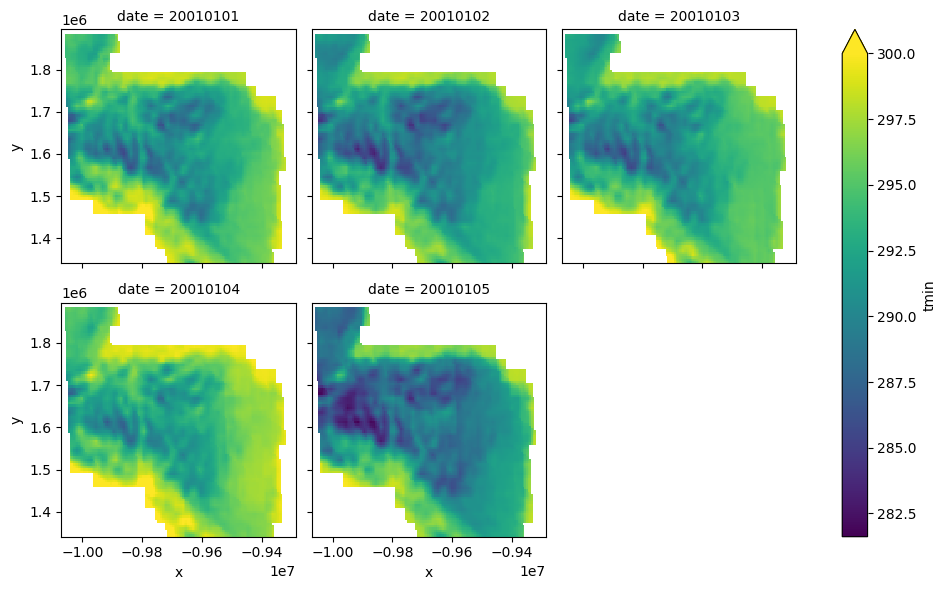

In [4]:
## plots

#spdata.climate.precipitation.isel(date = 200).plot(vmax = 100)
g_simple = spdata.climate.tmin.isel(date = list(range(5))).plot(x="x", y="y", col="date", col_wrap=3, vmax = 300)

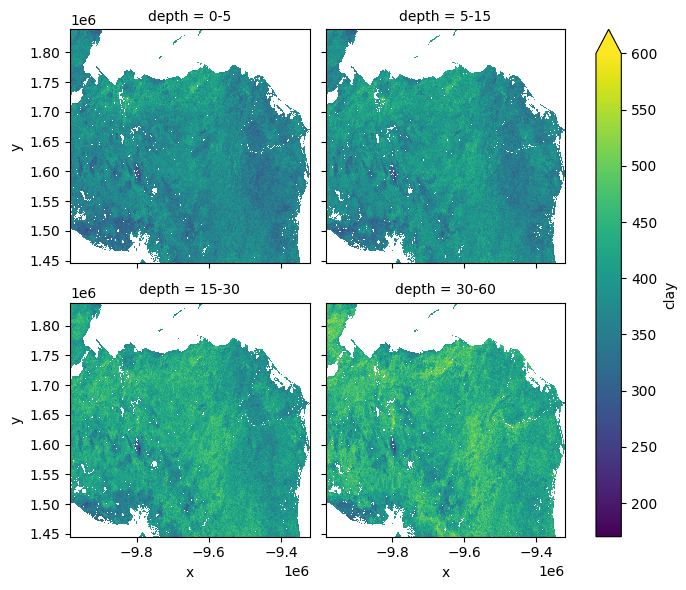

In [ ]:
# texture values in soil grids data is multiply by 10
g_simple = spdata.soil.clay.plot(x="x", y="y", col="depth", col_wrap=2, vmax = 600)

In [6]:
# save data as datacubes
spdata._save_asnc(spdata.soil, fn = 'soil/soil_hnd.nc')
spdata._save_asnc(spdata.climate, fn = 'weather/weather_hnd.nc')

## Crop modeling

Once the spatial data has been configured, the next step is to define the site-specific management unit. In this example, the management unit is defined by a combination of political division (village boundaries) and soil textural classification.

To specify political data, you can use the name of a feature in the geospatial file. For further spatial deatail, soil texture is used to gain a btter knowledge. Currently texture is the only grouping option available.

Other parameters to configure include crop parameters and management practices. Below is an example of how to define these parameters. For more examples, please check the options/dssat_options folder.


In [20]:
cm_configuration = {
    'GENERAL_INFO': {
        'country': 'Honduras',
        'country_code': 'HND', # crountry code
        'working_path': 'runs', # the model outputs will be located in this path
        'ncores': 10,
        'model': 'dssat',
        'bin_path': None
    },
    'SPATIAL_INFO':{
        'geospatial_path': 'data/tb_limitealdeas.shp', # spatial file that contains the region of interest
        'feature_name': 'GEOCODIGO', ## an unique code that represent each region of interest
        'aggregate_by' : 'texture',
        'soil_path' : 'soil/soil_hnd.nc',
        'weather_path': 'weather/weather_hnd.nc',
        'scale_factor': 10 # scale factor for soil and weather spatial resolution combination
    },
    'CROP': {
        'name': 'Maize', # crop name
        'cultivar': '990002', # cultivar
        'cultivar_file': None # optional for the cases that you have a cultivar that is not in DSSATTools default cultivars
    },
    'MANAGEMENT':{
        'planting_date': '2001-04-01',
        'harvesting_date': '2001-08-30',
        'plantingWindow': 15, # planting window in weeks
        'fertilizer': False, # It is not implemented yet
        'index_soilwat': 1,
        'template': 'crop_modeling/dssat/exp_files/KEAG8104.MZX'
    }
}

In [21]:
from spatialdata.soil_data import TEXTURE_CLASSES
from crop_modeling.spatial_process import SpatialCM
import os

# Initialize the spatial crop modeling class
cm_sp = SpatialCM(configuration_dict=cm_configuration)

loaded from soil/soil_hnd.nc
loaded from weather/weather_hnd.nc


In [48]:
# Specify the region of interest by its index
roi_index = 1000

# Create soil and weather files for the selected region
workingpath = cm_sp.create_roi_sp_data(
    roi_index=roi_index,
    group_codes=TEXTURE_CLASSES,  # Codes for grouping data by texture
    create_group_splayer=True  # Option to create a grouped spatial layer
)
if workingpath is not None:
    # Locate environmental working paths
    cm_sp.find_envworking_paths()

    # Set up crop files
    cm_sp.set_up_crop(crop=cm_sp.crop, cultivar=cm_sp.cultivar)

    # Set up management files
    cm_sp.set_up_management(crop=cm_sp.crop, cultivar=cm_sp.cultivar, **cm_sp.config.MANAGEMENT)

    # run the simulation
    completed_sims =cm_sp.run(cm_sp.crop_code, crop=cm_sp.crop,planting_window=cm_sp.config.MANAGEMENT.plantingWindow,
                            bin_path = cm_sp.config.GENERAL_INFO.bin_path, remove_tmp_folder=True)
    print(completed_sims)
else:
    print('there is no information')



sand 33.317569732666016 clay 37.83378219604492
sand 32.26250076293945 clay 40.73749923706055
Configuration file written: runs/161206/clay/experimental_file_config.yaml
experimental file created: ['runs/161206/clay/EXPS0001.MZX']
Configuration file written: runs/161206/clayloam/experimental_file_config.yaml
experimental file created: ['runs/161206/clayloam/EXPS0001.MZX']
{'clayloam': True}


In [49]:
from crop_modeling.dssat.output import DSSATOutputData
import plotly.express as px

## load the results

groupclasses = [
        i for i in os.listdir(cm_sp._tmp_path) if os.path.isdir(os.path.join(cm_sp._tmp_path, i)) and os.path.exists(os.path.join(cm_sp._tmp_path, i,'Summary_1.OUT'))
    ]

output_data = {
groupclasses[i]: DSSATOutputData(os.path.join(cm_sp._tmp_path, groupclasses[i]))
        for i in range(len(groupclasses))
}
groupclasses

runs/161206/clay
runs/161206/clayloam


['clay', 'clayloam']

In [50]:
### exporting the weather and potential yield outputs as data frames

weatherdatato = output_data[groupclasses[0]].weather_data()
weatherdatato.to_csv(os.path.join(cm_sp._tmp_path, 'weather.csv'))

potentialyield_data = []
for gval in groupclasses:
    dftmp = output_data[gval].output_data().sort_values("PDAT")
    dftmp = dftmp.loc[dftmp.HWAH != 0]
    dftmp['texture'] = gval
    potentialyield_data.append(dftmp)

potentialyield_data = pd.concat(potentialyield_data)

potentialyield_data.to_csv(os.path.join(cm_sp._tmp_path, 'potential_yield.csv'))

## delete temporary working path
import shutil
for groupfolder in groupclasses:
  shutil.rmtree(os.path.join(cm_sp._tmp_path, groupfolder), ignore_errors=False, onerror=None)


## Crop simulation outputs

After completing the simulation, the next step is to generate output plots. Three types of plots are created:

 - Spatial Variable Map: Displays the spatial variable (e.g., soil texture) used to define the specific context.
 - Climate Data Time Series Plot: Shows the time series of the climate data.
 - Potential Yield Plot: Illustrates potential yield across different planting date scenarios.


In [51]:
## texture layer
from spatialdata.gis_functions import xrarray_to_categorical_polygon
import rioxarray
import numpy as np
import pandas as pd
import plotly.graph_objects as go

## convert from tif to vector format
textdata = rioxarray.open_rasterio(os.path.join(cm_sp._tmp_path, "texture.tif"))
textdata = textdata.where(textdata < 1.79769313e38, np.nan)
texture_geo = xrarray_to_categorical_polygon(textdata.isel(band=0), "band_data")
texture_geo = texture_geo.rename(columns={"band_data": "texture"})
texture_geo["texture"] = texture_geo["texture"].map(lambda x: TEXTURE_CLASSES[int(x)])

texture_geo = texture_geo.to_crs('EPSG:4326')

x = np.mean(texture_geo.get_coordinates().x.values)
y = np.mean(texture_geo.get_coordinates().y.values)
fig = px.choropleth_map(
    texture_geo,
    geojson=texture_geo,
    color="texture", locations="texture", featureidkey="properties.texture", opacity=0.5,
    zoom=10, center={"lat": y, "lon": x},
)
fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(margin=dict(l=20, r=20, t=5, b=5))

/content/WeatherSoilDataProcessor/spatialdata/gis_functions.py:71: UserWarning:

Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.


/content/WeatherSoilDataProcessor/spatialdata/gis_functions.py:71: UserWarning:

Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




In [54]:
## weather plot

labels = {'RAIN': "Precipitation (mm) <br>Temperature (°C)", "monthday": "Date" }


weatherdatato['year'] = weatherdatato.DATE.dt.year

weatherdatato["TMIN"] = weatherdatato["TMIN"].map(lambda x: float(x))
weatherdatato["TMAX"] = weatherdatato["TMAX"].map(lambda x: float(x))
weatherdatato = pd.melt(weatherdatato.loc[:,['DATE','year', 'TMIN', 'TMAX','RAIN']], id_vars=['DATE','year','RAIN'], value_vars=['TMIN','TMAX'])
weatherdatato['monthday'] = weatherdatato.DATE.dt.strftime('%b-%d')

figwt = px.line(weatherdatato, x="monthday", y="value", animation_frame="year",color = 'variable')
weatherdatato = weatherdatato.loc[weatherdatato.variable == 'TMIN']
weatherdatato.loc[:,'Variable'] = 'Precipitation'
figwr = px.bar(weatherdatato, x="monthday", y="RAIN", animation_frame="year",color = 'Variable',
                        labels = labels)

figw = go.Figure(
    data=figwt.data + figwr.data,
    frames=[
        go.Frame(data=fr1.data + fr2.data, name=fr1.name)
        for fr1, fr2 in zip(figwt.frames, figwr.frames)
    ],
    layout=figwr.layout,
)
figw.show()

In [55]:
## potential yield

potentialyield_data['year'] = potentialyield_data.PDAT.dt.year
potentialyield_data['monthday'] = potentialyield_data.PDAT.dt.strftime('%b-%d')
datatoplot = potentialyield_data.sort_values("PDAT")
fig = px.line(datatoplot, x="monthday", y="HWAH", animation_frame="year",
            color="texture",  labels = labels)
fig.show()